# Story Generator - Winnie the Pooh 

## Part 1: Processsing Texts and Vector Database

[1. Imports and environment](#1-imports-and-environment)

[2. Inspect text](#2-inspect-text)

[3. Load and chunk data](#3-load-and-chunk-data)

[4. Chroma database](#4-chroma-database)

[5. Execute](#5-execute)

[6. Querying database](#6-querying-database)

[7. Readability](#7-readability)


### 1. Imports and environment

In [3]:
#pip install python-dotenv langchain langchain-community langchain-openai chromadb chromadbx pandas

In [7]:
from evaluation_metrics import calculate_readability_scores

import os 
import shutil 
from dotenv import load_dotenv 
import re 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langchain.text_splitter import RecursiveCharacterTextSplitter # for chunking text 
import chromadb 
from chromadb.utils import embedding_functions # ChromaDB embedding functions
from chromadbx import UUIDGenerator # for generating UUIDs 

default_ef = embedding_functions.DefaultEmbeddingFunction()

# Set up OpenAI API key
load_dotenv()
#openai_key = os.getenv('OPENAI_API_KEY')

# File paths
DATA_PATH = "../data/raw"
CHROMA_PATH = "../data/chroma_db"

### 2. Inspect text

In [8]:
with open(os.path.join(DATA_PATH, "winnie_the_pooh.txt"), 'r', encoding='utf-8') as file:
    full_text = file.read()

char_count = {}

# Count the number of times each character appears in the text
for char in full_text:
    if char in char_count:
        char_count[char] += 1
    else:
        char_count[char] = 1

print(f"Number of unique characters: {len(char_count.keys())} \n")

# Filter only non-alphanumeric characters
filtered_char_count = {char: count for char, count in char_count.items() if not char.isalnum()}
print("Non-alphanumeric characters: ")
print(filtered_char_count, "\n")

Number of unique characters: 79 

Non-alphanumeric characters: 
{' ': 23567, '-': 682, '\n': 3612, '_': 582, '.': 1692, '"': 2417, "'": 689, '&': 2, ',': 2187, '?': 342, '(': 27, ')': 27, '!': 252, ';': 55, '*': 38, ':': 43} 



In [9]:
# find instances of underscores in the text to see how they are used 
matches_1 = re.findall(r'.{0,20}\_.{0,20}', full_text)
for match in matches_1[:20]:
    print(match)

# find instances of asterisks in the text to see how they are used 
matches_2 = re.findall(r'.{0,30}\*.{0,30}', full_text)
for match in matches_2:
    print(match)

                    _BY A. A. MILNE_
                    _JUVENILES_
    "_The best book of ver
ses for children_ _ever written._"--A. 
    NEWTON in _The Atlantic Monthly
_.
                    _ESSAYS_
                    _MYSTERY STORY_
 voice, "What about _Me_?" "My dear Pigle
saying, "What about _Us_?" So perhaps the
on't you know what '_ther_' means?"
"_What_ about a story?" I s
mself. Because he's _that_ sort of Bear."
(_"What does 'under th
d Christopher Robin._
"_It means he had the 
under it._"
_"Winnie-the-Pooh was
d Christopher Robin._
_"Now I am," said a g
                 *        *        *        *        *
                 *        *        *        *        *
                 *        *        *        *        *
BANG!!!???***!!!
                 *        *        *        *        *
                 *        *        *        *        *
                 *        *        *        *        *
                 *        *        *        *        *


NOTE: Underscores and asterisks are not typical punctuations, so I want to check how they are being used in the text. Based on the results above, they both appear to be superfluous, and will be premoved in the processing/chunking steps. 

### 3. Load and chunk data

In [10]:
def load_documents(filepath, filename="winnie_the_pooh.txt"):
  """
  Load TXT documents from the specified directory. 
  Remove whitespace and split into individual stories by chapter.
  Filename defaults to winnie_the_pooh.txt, but can be specified for other files. 

  Returns:
    List of chapters, removing first title pages.
  """

  with open(os.path.join(filepath, filename), 'r', encoding='utf-8') as file:
    story = file.read()

    # remove whitespace, underscores, and asterisks
    story = re.sub(r'\s+', ' ', story)
    story = re.sub(r"_", "", story)
    story = re.sub(r"\*", "", story)

    #split into individual stories by chapter
    stories_list = story.split("CHAPTER ")
    
    return stories_list[1:] # first element is title pages. 


In [11]:
documents = load_documents(DATA_PATH) 

# Check results are as expected
print(f"Number of stories: {len(documents)} \n")
print(f"Length of first story: {len(documents[0])} \n")
print("Preview of first story: ")
print(f"{documents[0][:150]} ...")

Number of stories: 10 

Length of first story: 11613 

Preview of first story: 
I IN WHICH WE ARE INTRODUCED TO WINNIE-THE-POOH AND SOME BEES, AND THE STORIES BEGIN Here is Edward Bear, coming downstairs now, bump, bump, bump, on  ...


In [12]:

def split_text(text_list):
  """
  Split the text content of the given list of texts into smaller chunks.
  Args:
    text_list: List of documents/chapters containing text content to be split.
  Returns:
    list of chunks: List of Document objects representing the split text chunks.
    metadata: dataframe containing metadata for each chunk.
  """
  # Initialize text splitter with specified parameters
  text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200, # Size of each chunk in characters
    chunk_overlap=50, # Overlap between consecutive chunks
    length_function=len, # Function to compute the length of the text
    add_start_index=True, # Flag to add start index to each chunk
    )

  # Split documents into smaller chunks using text splitter
  chunks = [text_splitter.split_text(doc) for doc in text_list]

  text = []
  title = []
  author = []
  chapter = []
  chunk = []

  for i, story in enumerate(chunks):
      for j, c in enumerate(story):
          text.append(c)
          title.append("Winnie the Pooh")
          author.append("A. A. Milne")
          chapter.append(float(i+1))
          chunk.append(float(j))

  #metadata = {'title': title, 'author': author, 'chapter': chapter, 'chunk': chunk}
  metadata_df = pd.DataFrame({'title': title, 'author': author, 'chapter': chapter, 'chunk': chunk})

  return text, metadata_df


In [13]:
text, metadata = split_text(documents)

# Inspect text chunks
print(f"Total number of text chunks: {len(text)}")
print(f"Length of first text chunk: {len(text[0])}")
print("Preview of text chunks: ")
for chunk in text[:5]:
    print(" ", chunk[:100], "...")

Total number of text chunks: 796
Length of first text chunk: 200
Preview of text chunks: 
  I IN WHICH WE ARE INTRODUCED TO WINNIE-THE-POOH AND SOME BEES, AND THE STORIES BEGIN Here is Edward  ...
  back of his head, behind Christopher Robin. It is, as far as he knows, the only way of coming downst ...
  another way, if only he could stop bumping for a moment and think of it. And then he feels that perh ...
  at the bottom, and ready to be introduced to you. Winnie-the-Pooh. When I first heard his name, I sa ...
  was a boy?" "So did I," said Christopher Robin. "Then you can't call him Winnie?" "I don't." "But yo ...


In [14]:
# Inspect metadata
print(f"Total number of metadata entries: {len(metadata)}")
print("Preview of metadata: ")
print(metadata.head(), "\n")

# Chapters
print(f"Chapters: {metadata['chapter'].unique()} \n")

# Chunks
chunk_min = int(metadata['chunk'].min())
chunk_max = int(metadata['chunk'].max())
print(f"Chunks: {chunk_min} - {chunk_max} \n")

for chapter in metadata['chapter'].unique():
    chapter_chunks = metadata[metadata['chapter'] == chapter]
    print(f"Chapter {int(chapter)}: {int(chapter_chunks['chunk'].max())+1} chunks")

Total number of metadata entries: 796
Preview of metadata: 
             title       author  chapter  chunk
0  Winnie the Pooh  A. A. Milne      1.0    0.0
1  Winnie the Pooh  A. A. Milne      1.0    1.0
2  Winnie the Pooh  A. A. Milne      1.0    2.0
3  Winnie the Pooh  A. A. Milne      1.0    3.0
4  Winnie the Pooh  A. A. Milne      1.0    4.0 

Chapters: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] 

Chunks: 0 - 109 

Chapter 1: 78 chunks
Chapter 2: 54 chunks
Chapter 3: 46 chunks
Chapter 4: 52 chunks
Chapter 5: 93 chunks
Chapter 6: 96 chunks
Chapter 7: 104 chunks
Chapter 8: 110 chunks
Chapter 9: 94 chunks
Chapter 10: 69 chunks


### 4. Chroma database

In [15]:
def save_to_chroma(chunks: list, metadata_df: pd.DataFrame):
  """
  Save the given list of chunks and metadata to a Chroma database.
  Args:
    chunks (list): List of split texts representing text chunks to save.
    metadata_df (pd.DataFrame): DataFrame containing metadata for each chunk.
  Returns:
    None
  """
  
  # Clear out the existing database directory if it exists
  if os.path.exists(CHROMA_PATH):
    shutil.rmtree(CHROMA_PATH)
    

  # Create a new Chroma vector database & collection
  client = chromadb.PersistentClient(path=CHROMA_PATH)
  collection = client.get_or_create_collection(name="winnie_the_pooh", embedding_function=default_ef)
  
  collection.add(
    documents=chunks,
    metadatas=[dict(metadata_df.iloc[i]) for i in range(len(metadata_df))], 
    ids=UUIDGenerator(len(chunks))
    )


### 4. Execute

In [16]:
def generate_data_store():
  """
  Function to generate vector database in chroma from documents.
  """
  documents = load_documents(DATA_PATH) # Load documents from a source
  chunks, metadata = split_text(documents) # Split documents into manageable chunks
  save_to_chroma(chunks, metadata) # Save the processed data to a data store

In [17]:

# Load environment variables from a .env file
load_dotenv()
# Generate the data store
generate_data_store()

### 6. Querying database

Checking the database is populated with expected vectors and data.

In [18]:
client = chromadb.PersistentClient(path=CHROMA_PATH)
collection = client.get_collection(name="winnie_the_pooh", embedding_function=default_ef)

results = collection.query(query_texts='honey', n_results=3)
results.keys()

dict_keys(['ids', 'embeddings', 'documents', 'uris', 'data', 'metadatas', 'distances', 'included'])

In [19]:
print(f"Cosine Similarity Distances: {results['distances']} \n")

for i in range(len(results['documents'][0])):
    print(f"Chapter: {results['metadatas'][0][i]['chapter']}, Chunk: {results['metadatas'][0][i]['chunk']}")
    print(results['documents'][0][i], " \n")

Cosine Similarity Distances: [[1.084073543548584, 1.0937860012054443, 1.10151207447052]] 

Chapter: 1.0, Chunk: 17.0
then he got up, and said: "And the only reason for making honey is so as I can eat it." So he began to climb the tree. He climbed and he climbed and he climbed, and as he climbed he sang a little  

Chapter: 5.0, Chunk: 29.0
so as not to hurt myself, and I would get to the Jar of Honey, and I should lick round the edges first of all, pretending that there wasn't any more, you know, and then I should walk away and think  

Chapter: 5.0, Chunk: 51.0
there. A full jar, full of honey right up to the top, and it had HUNNY written on it, so that I should know it was honey. That's very funny." And then he began to wander up and down, wondering where  



In [20]:
results

{'ids': [['3ac39b49-2cbd-4a32-b871-51b1fd945193',
   '9a2c7782-2730-4b50-9be7-21d73fc08fdc',
   '3d0b92c6-279a-4f52-a8d8-b968353d1703']],
 'embeddings': None,
 'documents': [['then he got up, and said: "And the only reason for making honey is so as I can eat it." So he began to climb the tree. He climbed and he climbed and he climbed, and as he climbed he sang a little',
   "so as not to hurt myself, and I would get to the Jar of Honey, and I should lick round the edges first of all, pretending that there wasn't any more, you know, and then I should walk away and think",
   'there. A full jar, full of honey right up to the top, and it had HUNNY written on it, so that I should know it was honey. That\'s very funny." And then he began to wander up and down, wondering where']],
 'uris': None,
 'data': None,
 'metadatas': [[{'author': 'A. A. Milne',
    'chapter': 1.0,
    'chunk': 17.0,
    'title': 'Winnie the Pooh'},
   {'author': 'A. A. Milne',
    'chapter': 5.0,
    'chunk': 29.0,
  

### 7. Readability
Core measurements are word length and sentence length. 


**Flesch–Kincaid grade level** 
- score is grade level, where lowest possible score is -3.40 (ex. Dr. Suess' Green Eggs and Ham has a grade level of -1.3)

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/8e68f5fc959d052d1123b85758065afecc4150c3"
     alt="Flesch-Kincaid grade formula"
     style="margin-left: 45px;" 
     />



**Flesch reading ease**
- scored 0-100, where high scores indicate material that is easy to read and low numbers are difficult.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/bd4916e193d2f96fa3b74ee258aaa6fe242e110e"
     alt="Flesch-Kincaid grade formula"
     style="margin-left: 45px;" 
     />


In [21]:
chapter_scores = {}

for i in range(len(documents)):
    chapter = i + 1
    story = documents[i]
    chapter_scores[chapter] = calculate_readability_scores(story)

scores_df = pd.DataFrame(chapter_scores).T

print(f"mean Flesch-Kincaid grade: {np.mean(scores_df['Flesch-Kincaid Grade']):.1f}")
print(f"median Flesch-Kincaid grade: {np.median(scores_df['Flesch-Kincaid Grade']):.1f}")
print(f"standard dev. Flesch-Kincaid grade: {np.std(scores_df['Flesch-Kincaid Grade']):.1f}")
print(f"max Flesch-Kincaid grade: {np.max(scores_df['Flesch-Kincaid Grade']):.1f}")

mean Flesch-Kincaid grade: 3.8
median Flesch-Kincaid grade: 3.7
standard dev. Flesch-Kincaid grade: 0.8
max Flesch-Kincaid grade: 5.5


Text(0.5, 1.0, 'Original Winnie the Pooh Text\nFlesch-Kincaid Grade Distribution')

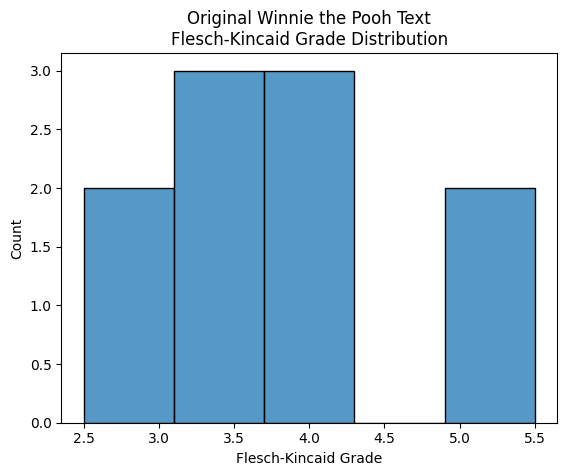

In [22]:
sns.histplot(scores_df['Flesch-Kincaid Grade'], bins=5)
plt.title("Original Winnie the Pooh Text\nFlesch-Kincaid Grade Distribution")